### Méthodes pour preprocessing

In [1]:
import string
import nltk
nltk.download('wordnet')
from nltk import tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

[nltk_data] Downloading package wordnet to /home/slerendu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def get_wordnet_pos(word):
    """Return the corresponding character for a word use in the lemmatization
    
    Parameters:
    word (str): a word
    
    Returns:
    str: the corresponding character
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [3]:
def detailled_lemmatizer(sentence):
    """Lemmatize a sentence and return it
    
    Parameters:
    sentence (list(str)): a list of words
    
    Returns:
    (list(str)): a list of lemmatized words
    """
    lemmatizer = WordNetLemmatizer()
    result = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in sentence]
    return result

In [4]:
def preprocessing_words(df, col, stem_or_lemma="stem", debug=False):
    """Compute all the basics string tranformations in NLP
    Normalisation, Tokenization, Remove of stopwords, Stemmation or Lemmatization
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words
    """
    result = []    
    # building stopwords list
    stopW = stopwords.words('english')
    stopW.extend(string.punctuation)
    
    for index, row in df.iterrows():
        temp_res = ""
        # normalisation
        temp_res = row[col].lower()
        # tokenization
        temp_res = tokenize.word_tokenize(temp_res)
        # remove stopwords
        temp_res = [word for word in temp_res if word not in stopW]
        
        # stemmation or lemmatization
        if stem_or_lemma == "stem":
            stemmer = PorterStemmer()
            temp_res = [stemmer.stem(elt) for elt in temp_res]
        elif stem_or_lemma == "lemma":
            temp_res = detailled_lemmatizer(temp_res)
            # lemmatizer = WordNetLemmatizer()
            # temp_res = [lemmatizer.lemmatize(elt) for elt in temp_res]
        else:
            print("stem or lemma only")
        
        result.append(temp_res)
    return result

In [5]:
def filter_pos_tag(df, col, tags_to_remove=[], debug=False):
    """Filter words from a list of Part-Of-Speech tags
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    tags_to_remove list(str): a list of POS tag
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not tags_to_remove:
        print("Aucun filtre n'a été défini.")
        return df[col]
    for index, row in df.iterrows():
        temp_res = pos_tag(row[col])
        temp_res = [x for x in temp_res if x[1] not in tags_to_remove]
        # if debug:
        #     print(temp_res[0])
        result.append([x[0] for x in temp_res])
    return result

In [6]:
def filter_exclude_words(df, col, words_to_exclude=[], debug=False):
    """Filter words from a list of specific words
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    words_to_exclude list(str): a list of words
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    result = []
    if not words_to_exclude:
        print("Aucun mots à exclure.")
        return df[col]
    for index, row in df.iterrows():
        result.append([x for x in row[col] if x not in words_to_exclude])
    return result

In [7]:
def display_wordcloud(corpus, debug=False):
    """Display a WordCloud picture from a corpus
    
    Parameters:
    corpus (dict): a Counter dictionary with the frequency of each words
    debug (bool): show debug elements
    
    Returns:
    
    """
    wordcloud = WordCloud(
            random_state = 42,
            normalize_plurals = False,
            width = 600, 
            height= 300,
            max_words = 100,
            stopwords = [],
            colormap="BrBG")

    wordcloud.generate_from_frequencies(corpus)
    
    fig, ax = plt.subplots(1,1, figsize = (12,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

In [8]:
def natural_language_processing(
    df, col, stem_or_lemma="stem", tags_to_remove=[], words_to_exclude=[],
    max_threshold=999, min_threshold=0, word_cloud=True, debug=False):
    """Compute NLP preprocessing methods
    
    Parameters:
    df (dataframe): input dataframe
    col (str): column to process
    stem_or_lemma (str): choose between stemmation or lemmatization
    tags_to_remove list(str): a list of POS tag
    words_to_exclude list(str): a list of words
    max_threshold (int): upper threshold to filter word frequency
    min_threshold (int): lower threshold to filter word frequency
    word_cloud (bool): display WordCloud representation
    debug (bool): show debug elements
    
    Returns:
    list(list(str)): return a list of document. Each document is a list of words    
    """
    # df = input_df.copy()
    # preprocessing part
    preproc_res = preprocessing_words(df, col, stem_or_lemma=stem_or_lemma, debug=debug)
    df.insert(0, 'preproc_text', preproc_res)
    # if debug:
    #     display(df[[col, 'preproc_text']].head())
    
    # filter by pos tag part
    filtpos_res = filter_pos_tag(df, "preproc_text", tags_to_remove=tags_to_remove, debug=debug)
    df.insert(0, 'filtpos_text', filtpos_res)
    # if debug:
    #     display(df[[col, 'preproc_text', 'filtpos_text']].head())
    
    # filter by excluding words
    filtexcl_words = filter_exclude_words(df, "filtpos_text", words_to_exclude=words_to_exclude, debug=debug)
    df.insert(0, 'filtexcl_words', filtexcl_words)
    
    if debug:
        display(df[[col, 'preproc_text', 'filtpos_text', 'filtexcl_words']].head())
    
    # concatenate all documents into a single corpus
    corpus = df["filtexcl_words"].tolist()
    corpus = [item for sublist in corpus for item in sublist]
    
    word_counts = Counter(corpus)
    print("Il y a un total de", len(word_counts), "mots différents dans tout le corpus.")
    word_counts_threshold = {x: count for x, count in word_counts.items() if count > min_threshold}
    word_counts_threshold = {x: count for x, count in word_counts_threshold.items() if count < max_threshold}
    print("Après filtrage, on garde les mots aparaissant plus de", min_threshold,
          "fois et moins de", max_threshold, "fois. Il reste alors",
          len(word_counts_threshold), "mots différents dans tout le corpus.\n")
    word_counts = Counter(word_counts_threshold)
    # print(word_counts)
    
    if debug:
        print("------------ Top 20 plus communs : ------------")
        display_most_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common(20)]
        for elt in display_most_common:
            print(elt)
        print("\n------------ Top 20 moins communs : ------------")
        display_least_common = [(i, word_counts[i], word_counts[i] / len(corpus) * 100.0) for i, count in word_counts.most_common()[-20:]]
        for elt in display_least_common:
            print(elt)
        
    simplified_corpus = word_counts_threshold.keys()
    
    # display wordcloud part
    if word_cloud:
        display_wordcloud(word_counts_threshold, debug=debug)
    
    return simplified_corpus

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
def representation_by_tf_idf(corpus):
    """Compute corpus into a tf-idf vectorisation
    
    Parameters:
    corpus (list(list(str)): a list of documents
    
    Returns:
    a matrix of TF-IDF features
    the list of features names
    """
    vect = TfidfVectorizer(ngram_range=(1, 1))
    tfidf_mat = vect.fit_transform(corpus)
    features_names = vect.get_feature_names_out()
    return tfidf_mat, features_names

In [10]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
def representation_by_word2vec(simplified_documents):
    """Compute corpus into a Word2vec vectorisation
    
    Parameters:
    simplified_documents (list(list(str)): a list of documents
    
    Returns:
    the model trained
    """
    model_W2V = Word2Vec(sentences=simplified_documents, vector_size=100, window=5, min_count=300, workers=4)
    model_W2V.train(simplified_documents, total_examples=len(simplified_documents), epochs=50)
    return model_W2V

In [11]:
def display_tsne_plot(model):
    """Display a t-SNE plot from Word Embedding transformation
    
    Parameters:
    model : the Word2vec model trained
    
    Returns:
    
    """
    word_labels = []
    tokens = np.empty((0,100), dtype='f')

    for wrd_score in model.wv.key_to_index:
        wrd_vector = model.wv[wrd_score]
        word_labels.append(wrd_score)
        tokens = np.append(tokens, np.array([wrd_vector]), axis=0)

    tsne_model = TSNE(perplexity=tokens.shape[0]-1, n_components=2, init='pca', n_iter=2500, random_state=42)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(16, 8)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(word_labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

### Import des données

In [12]:
import numpy as np
import pandas as pd

In [13]:
data = pd.read_csv('study_dataset.csv', encoding='utf-8', sep='\t', index_col=0)
data.head()

,business_id,name,stars,text
882258,TyYpzJzeKWtyMdPFtPRUEg,Prince Pizza,1,This place was horrible! They got my entire or...
642407,LCMpkeQWHdCbuX0Nlkmeow,Jack in the Box,1,I have no idea why I bother. It's the closest ...
831418,AZ42H2kk4JUiskC9NPoUjw,Hobnobber's Variety Bar & Restaurant,1,After reading glowing reviews of staff and foo...
452134,0CeoONLXqseUxPdGerefOQ,Mexican Post,1,Horrible Ground beef/bean Chimichanga. There w...
921422,QYEiZzwL8I4-q_3U0bq0eQ,The Nutrition Factory,1,They are usually awesome but picked up a kale ...


In [14]:
# nombre de reviews
data.shape

(3887, 4)

In [15]:
# nombre de restaurants
data["business_id"].nunique()

3404

### Preprocessing

Il y a un total de 9382 mots différents dans tout le corpus.
Après filtrage, on garde les mots aparaissant plus de 200 fois et moins de 1000 fois. Il reste alors 114 mots différents dans tout le corpus.



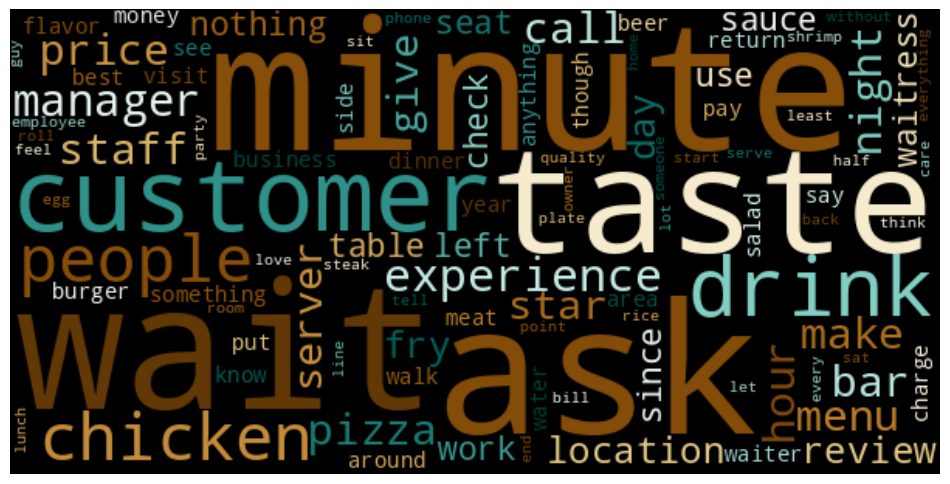

In [16]:
# ponctuation restante dans le top 10
words_to_exclude = [
    "``", "''", ".", "..", "...", "....", "....."
]
# mots à supprimer
words_to_exclude += [
    "get", "like", "go", "come", "take", "try", "told", "look", "another", "way",
    "restaurant", "thing", "wife", "husband", "u", "meal", "friend", "eat"
]

corpus = natural_language_processing(
    data, "text", stem_or_lemma="lemma", words_to_exclude=words_to_exclude,
    tags_to_remove=["JJ", "RB", "MD", "POS", "CD", ":", "PRP", "VBP"],
    max_threshold=1000, min_threshold=200, debug=False)

### Bag of Words et Word Embedding

In [17]:
tfidf_mat, features_names = representation_by_tf_idf(corpus)

In [19]:
from gensim.models import LdaModel
from gensim.corpora import Dictionary
from sklearn.model_selection import ParameterGrid
from gensim.models.coherencemodel import CoherenceModel

In [20]:
# préparation des données pour l'optimisation
documents = data["filtexcl_words"].tolist()
simplified_documents = []
for doc in documents:
    simplified_documents.append([x for x in doc if x in corpus])
dictionary = Dictionary(simplified_documents)
corpus_gensim = [dictionary.doc2bow(doc) for doc in simplified_documents]    

In [21]:
model_W2V = representation_by_word2vec(simplified_documents)

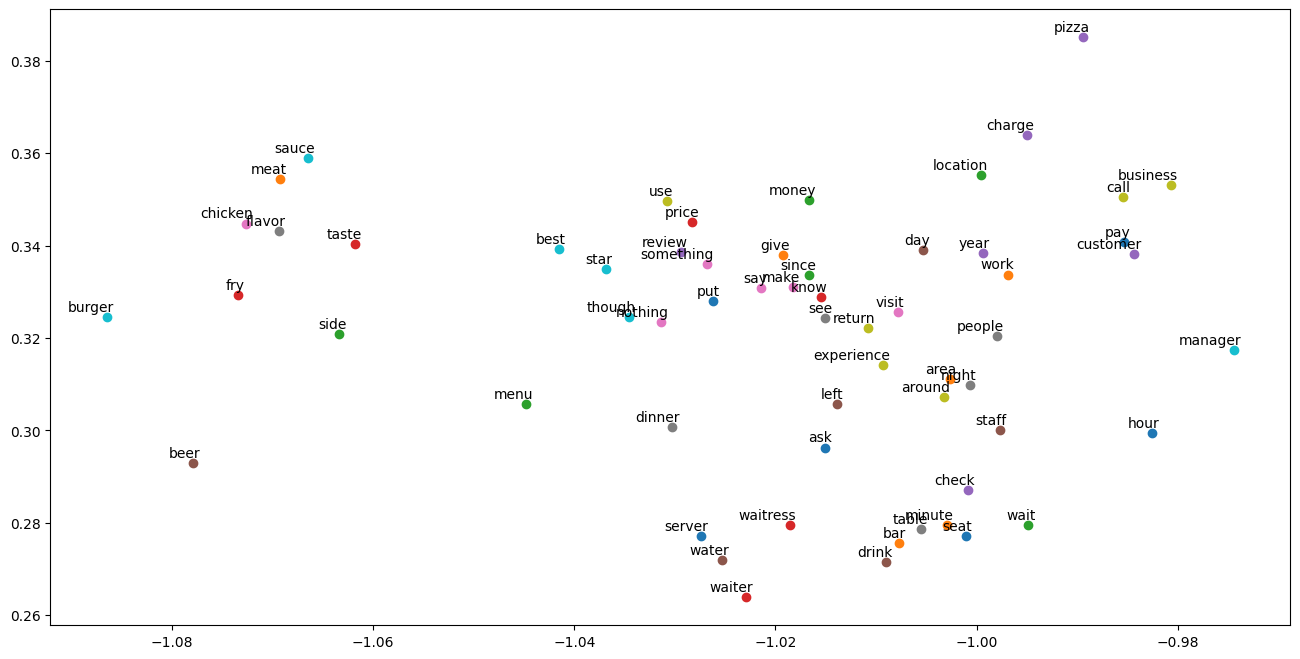

In [22]:
display_tsne_plot(model_W2V)

## LDA et NMF sklearn

In [23]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [24]:
def get_topics(model, feature_names, no_top_words):
    word_dict = {};
    for topic_idx, topic in enumerate(model.components_):
        word_dict['Topic' + '{:02d}'.format(topic_idx+1)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
    display(pd.DataFrame(word_dict).head(no_top_words))
    return word_dict

### LDA

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
def display_lda(tf, n_components):
    lda = LatentDirichletAllocation(n_components=n_components, random_state=42)
    lda.fit(tf)
    no_top_words = 5
    # display_topics(lda, features_names, no_top_words)
    word_dict = get_topics(lda, features_names, no_top_words)

In [26]:
# for n_topics in [5, 7, 10, 15, 20]:
#     print("-"*70)
#     print("Compute", n_topics, "topics...")
#     display_lda(tfidf_mat, n_topics)

### NMF

In [27]:
from sklearn.decomposition import NMF
def display_nmf(tf, n_components):
    nmf = NMF(n_components=n_components, random_state=42)
    nmf.fit(tf)
    no_top_words = 5
    # display_topics(nmf, features_names, no_top_words)
    get_topics(nmf, features_names, no_top_words)

In [28]:
# for n_topics in [5, 10, 15, 20]:
#     print("-"*70)
#     print("Compute", n_topics, "topics...")
#     display_nmf(tfidf_mat, n_topics)

## LDA Gensim

In [29]:
# paramètres à tester pour l'optimisation
param_grid = {
    'num_topics': [5, 7, 10, 15, 20],
    'passes': [20, 30, 40]
}

In [30]:
results = []
best_model = None
best_coherence_score = -1
best_list_model = {}

for params in ParameterGrid(param_grid):
    if not best_list_model.get(params["num_topics"], False):
        best_list_model[params["num_topics"]] = (None, -1)
    # Entraînement du modèle LDA avec les paramètres donnés
    lda_model = LdaModel(corpus=corpus_gensim, id2word=dictionary, random_state=42, **params)
    
    # Calcul de la cohérence des sujets
    coherence_model = CoherenceModel(model=lda_model, texts=documents, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    
    # Stockage des résultats
    results.append((params, coherence_score))
    if coherence_score > best_list_model[params["num_topics"]][1]:
        best_list_model[params["num_topics"]] = (lda_model, coherence_score)
    
    # Mise à jour du meilleur modèle si le score de cohérence est plus élevé
    if coherence_score > best_coherence_score:
        best_model = lda_model
        best_coherence_score = coherence_score    

In [31]:
# Affichage du meilleur modèle et de son score de cohérence
print("Meilleur modèle :")
print(best_model)
print("Score de cohérence des sujets :", best_coherence_score)

print("\n", "=====================================", "\n")

# Affichage des thèmes pour best_model
topics = best_model.print_topics(num_topics=20, num_words=5)
for topic in topics:
    print(topic)

Meilleur modèle :
LdaModel<num_terms=114, num_topics=7, decay=0.5, chunksize=2000>
Score de cohérence des sujets : 0.49620218388859794


(0, '0.101*"call" + 0.100*"wait" + 0.095*"hour" + 0.074*"location" + 0.054*"minute"')
(1, '0.072*"burger" + 0.056*"salad" + 0.053*"fry" + 0.042*"sandwich" + 0.039*"lunch"')
(2, '0.059*"taste" + 0.055*"day" + 0.054*"bar" + 0.048*"water" + 0.047*"coffee"')
(3, '0.073*"chicken" + 0.062*"taste" + 0.054*"meat" + 0.054*"sauce" + 0.044*"rice"')
(4, '0.074*"minute" + 0.059*"drink" + 0.049*"server" + 0.048*"ask" + 0.047*"wait"')
(5, '0.150*"pizza" + 0.110*"price" + 0.064*"quality" + 0.056*"item" + 0.053*"menu"')
(6, '0.073*"customer" + 0.042*"people" + 0.040*"work" + 0.037*"business" + 0.037*"employee"')


In [32]:
# Affiche du meilleur modèle par nombre de topic
for key, value in best_list_model.items():
    print("=====================================", "\n")
    print("Params:", key, "score :", value[1])
    topics = value[0].print_topics(num_topics=20, num_words=5)
    for topic in topics:
        print(topic)


Params: 5 score : 0.4735809162460063
(0, '0.074*"customer" + 0.052*"call" + 0.049*"location" + 0.044*"manager" + 0.035*"people"')
(1, '0.069*"chicken" + 0.062*"fry" + 0.052*"burger" + 0.042*"salad" + 0.039*"menu"')
(2, '0.054*"price" + 0.036*"year" + 0.034*"use" + 0.034*"day" + 0.033*"visit"')
(3, '0.098*"pizza" + 0.076*"taste" + 0.057*"sauce" + 0.052*"rice" + 0.050*"meat"')
(4, '0.064*"minute" + 0.064*"wait" + 0.050*"drink" + 0.043*"bar" + 0.039*"ask"')

Params: 7 score : 0.49620218388859794
(0, '0.101*"call" + 0.100*"wait" + 0.095*"hour" + 0.074*"location" + 0.054*"minute"')
(1, '0.072*"burger" + 0.056*"salad" + 0.053*"fry" + 0.042*"sandwich" + 0.039*"lunch"')
(2, '0.059*"taste" + 0.055*"day" + 0.054*"bar" + 0.048*"water" + 0.047*"coffee"')
(3, '0.073*"chicken" + 0.062*"taste" + 0.054*"meat" + 0.054*"sauce" + 0.044*"rice"')
(4, '0.074*"minute" + 0.059*"drink" + 0.049*"server" + 0.048*"ask" + 0.047*"wait"')
(5, '0.150*"pizza" + 0.110*"price" + 0.064*"quality" + 0.056*"item" + 0.053*"

In [33]:
# # représentation graphique de la déteection par LDA
# from pyLDAvis import gensim as ldavis_gen
# import pyLDAvis
# model = LdaModel(corpus=corpus_gensim, id2word=dictionary, num_topics=7, passes=20, random_state=42)
# lda_display = ldavis_gen.prepare(model, corpus_gensim, dictionary, sort_topics=False)
# pyLDAvis.display(lda_display)